In [241]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt

import darts
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.models import ExponentialSmoothing, TFTModel
from darts.utils.utils import ModelMode, SeasonalityMode
from dateutil.relativedelta import relativedelta
import duckdb

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

pd.options.mode.chained_assignment = None 

In [73]:
def query_ticker_data():
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_by_month`
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df


def test_p_value(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')


def stationarity_test(data):
    test_p_value(data['volume_weighted_average_price'])


def plot_history(data):
    plt.figure(figsize=(20, 10), dpi=150)
    plt.plot(data.index, data.volume_weighted_average_price, color='tab:blue')
    plt.gca().set(title=f'{data.name} Stock History', xlabel='Date', ylabel='$')
    plt.show()


def plot_trend(data):
    plt.figure(figsize=(20, 10), dpi=150)
    plt.plot(data.index, data.volume_weighted_average_price, color='tab:blue')
    plt.gca().set(title=f'{data.name} Stock History', xlabel='Date', ylabel='$')
    data['volume_weighted_average_price'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
    data['volume_weighted_average_price'].rolling(12).std().plot(label='12 STD')
    data['volume_weighted_average_price'].plot()
    plt.legend()


In [74]:
all = query_ticker_data().set_index('date')
all['log-volume'] = np.log(all['volume'])

In [75]:
apple = all[all['ticker'] == 'AAPL']
netflix = all[all['ticker'] == 'NFLX']
microsoft = all[all['ticker'] == 'MSFT']
amazon = all[all['ticker'] == 'AMZN']
alphabet = all[all['ticker'] == 'GOOGL']
coke = all[all['ticker'] == 'KO']

In [76]:
apple.name = "Apple"
netflix.name = "Netflix"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [252]:
TARGET_DF = netflix

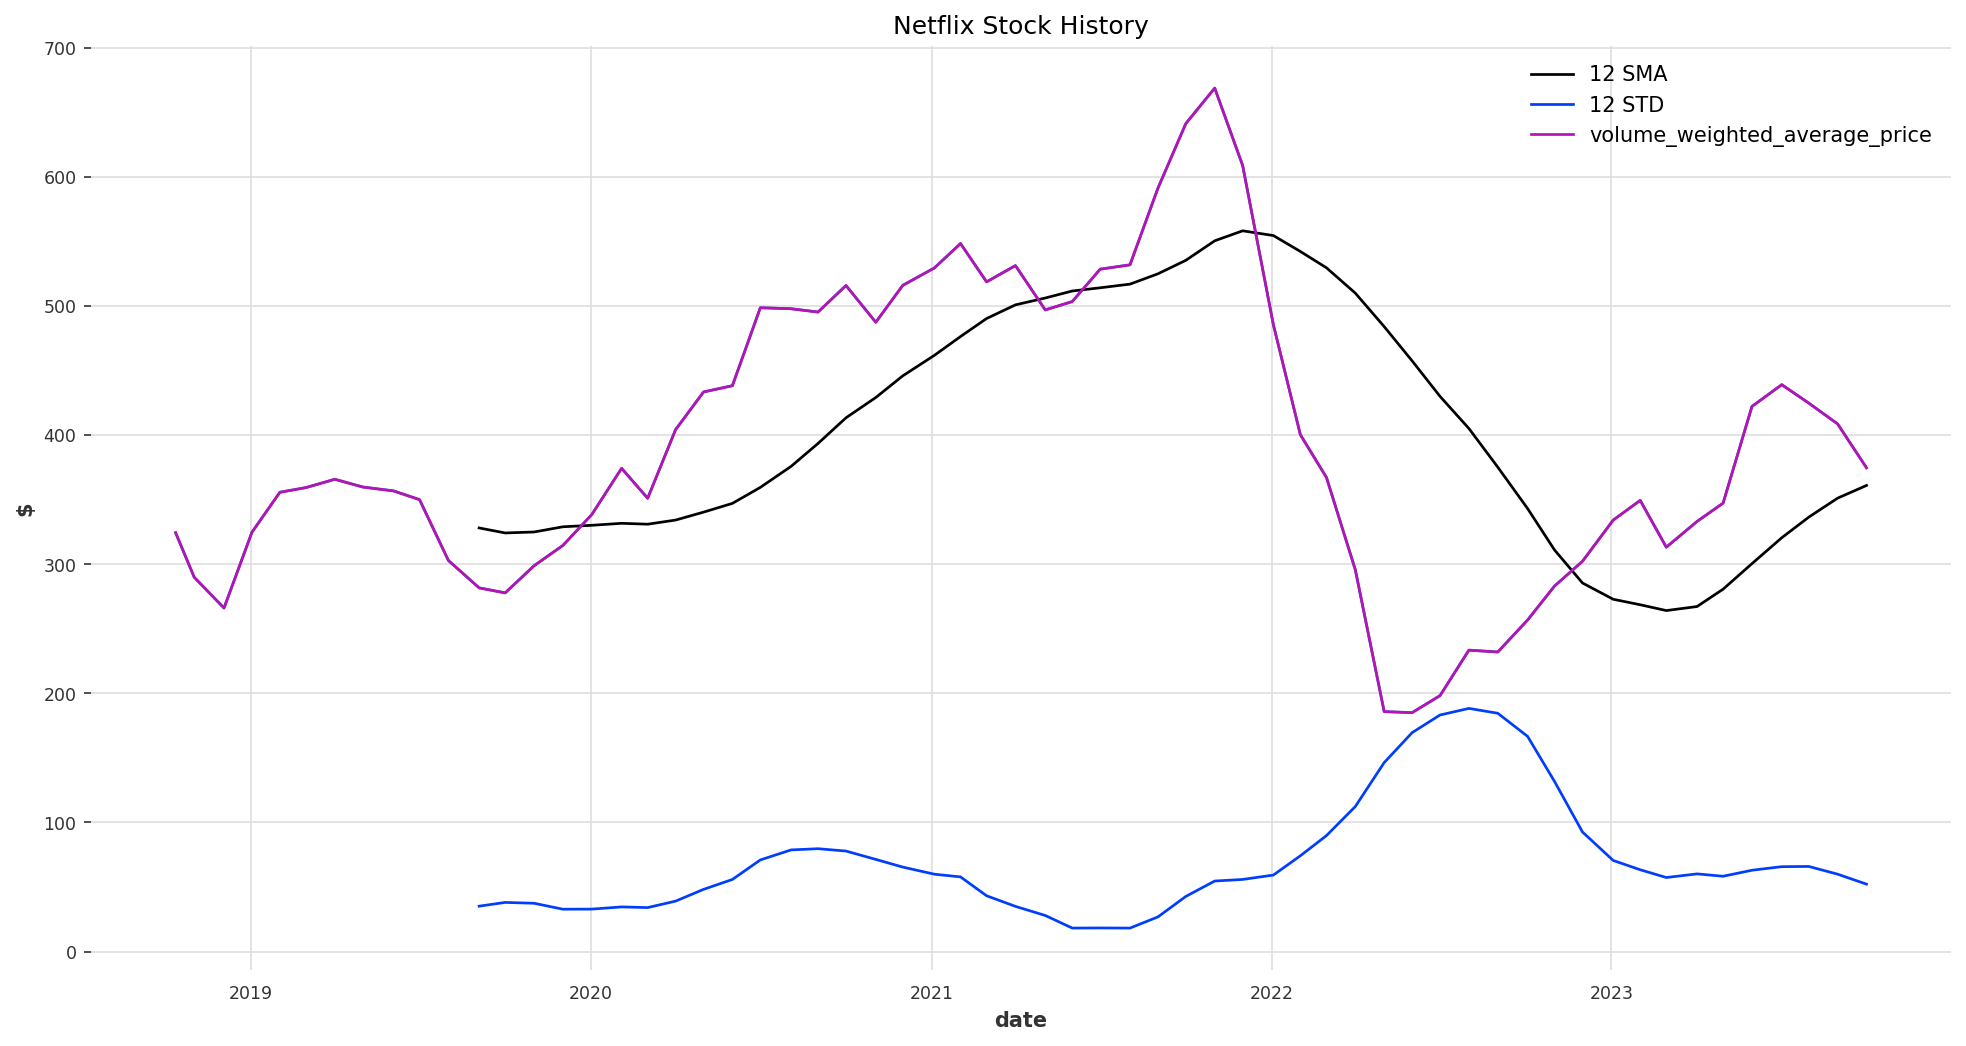

In [253]:
plot_trend(TARGET_DF)

In [254]:
df_series = TARGET_DF['volume_weighted_average_price'].reset_index()
max_dt = df_series.iloc[:-12]['date'].max()
min_dt = df_series.iloc[:-12]['date'].min()
max_dt

datetime.date(2022, 10, 3)

In [255]:
df_series = df_series.drop('date', axis=1)
series = TimeSeries.from_dataframe(df_series)
# Set aside the last 12 months as a test series
train, test = series[:-12], series[-12:]

In [256]:
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
model.fit(train)
prediction = model.predict(len(test), num_samples=1000)

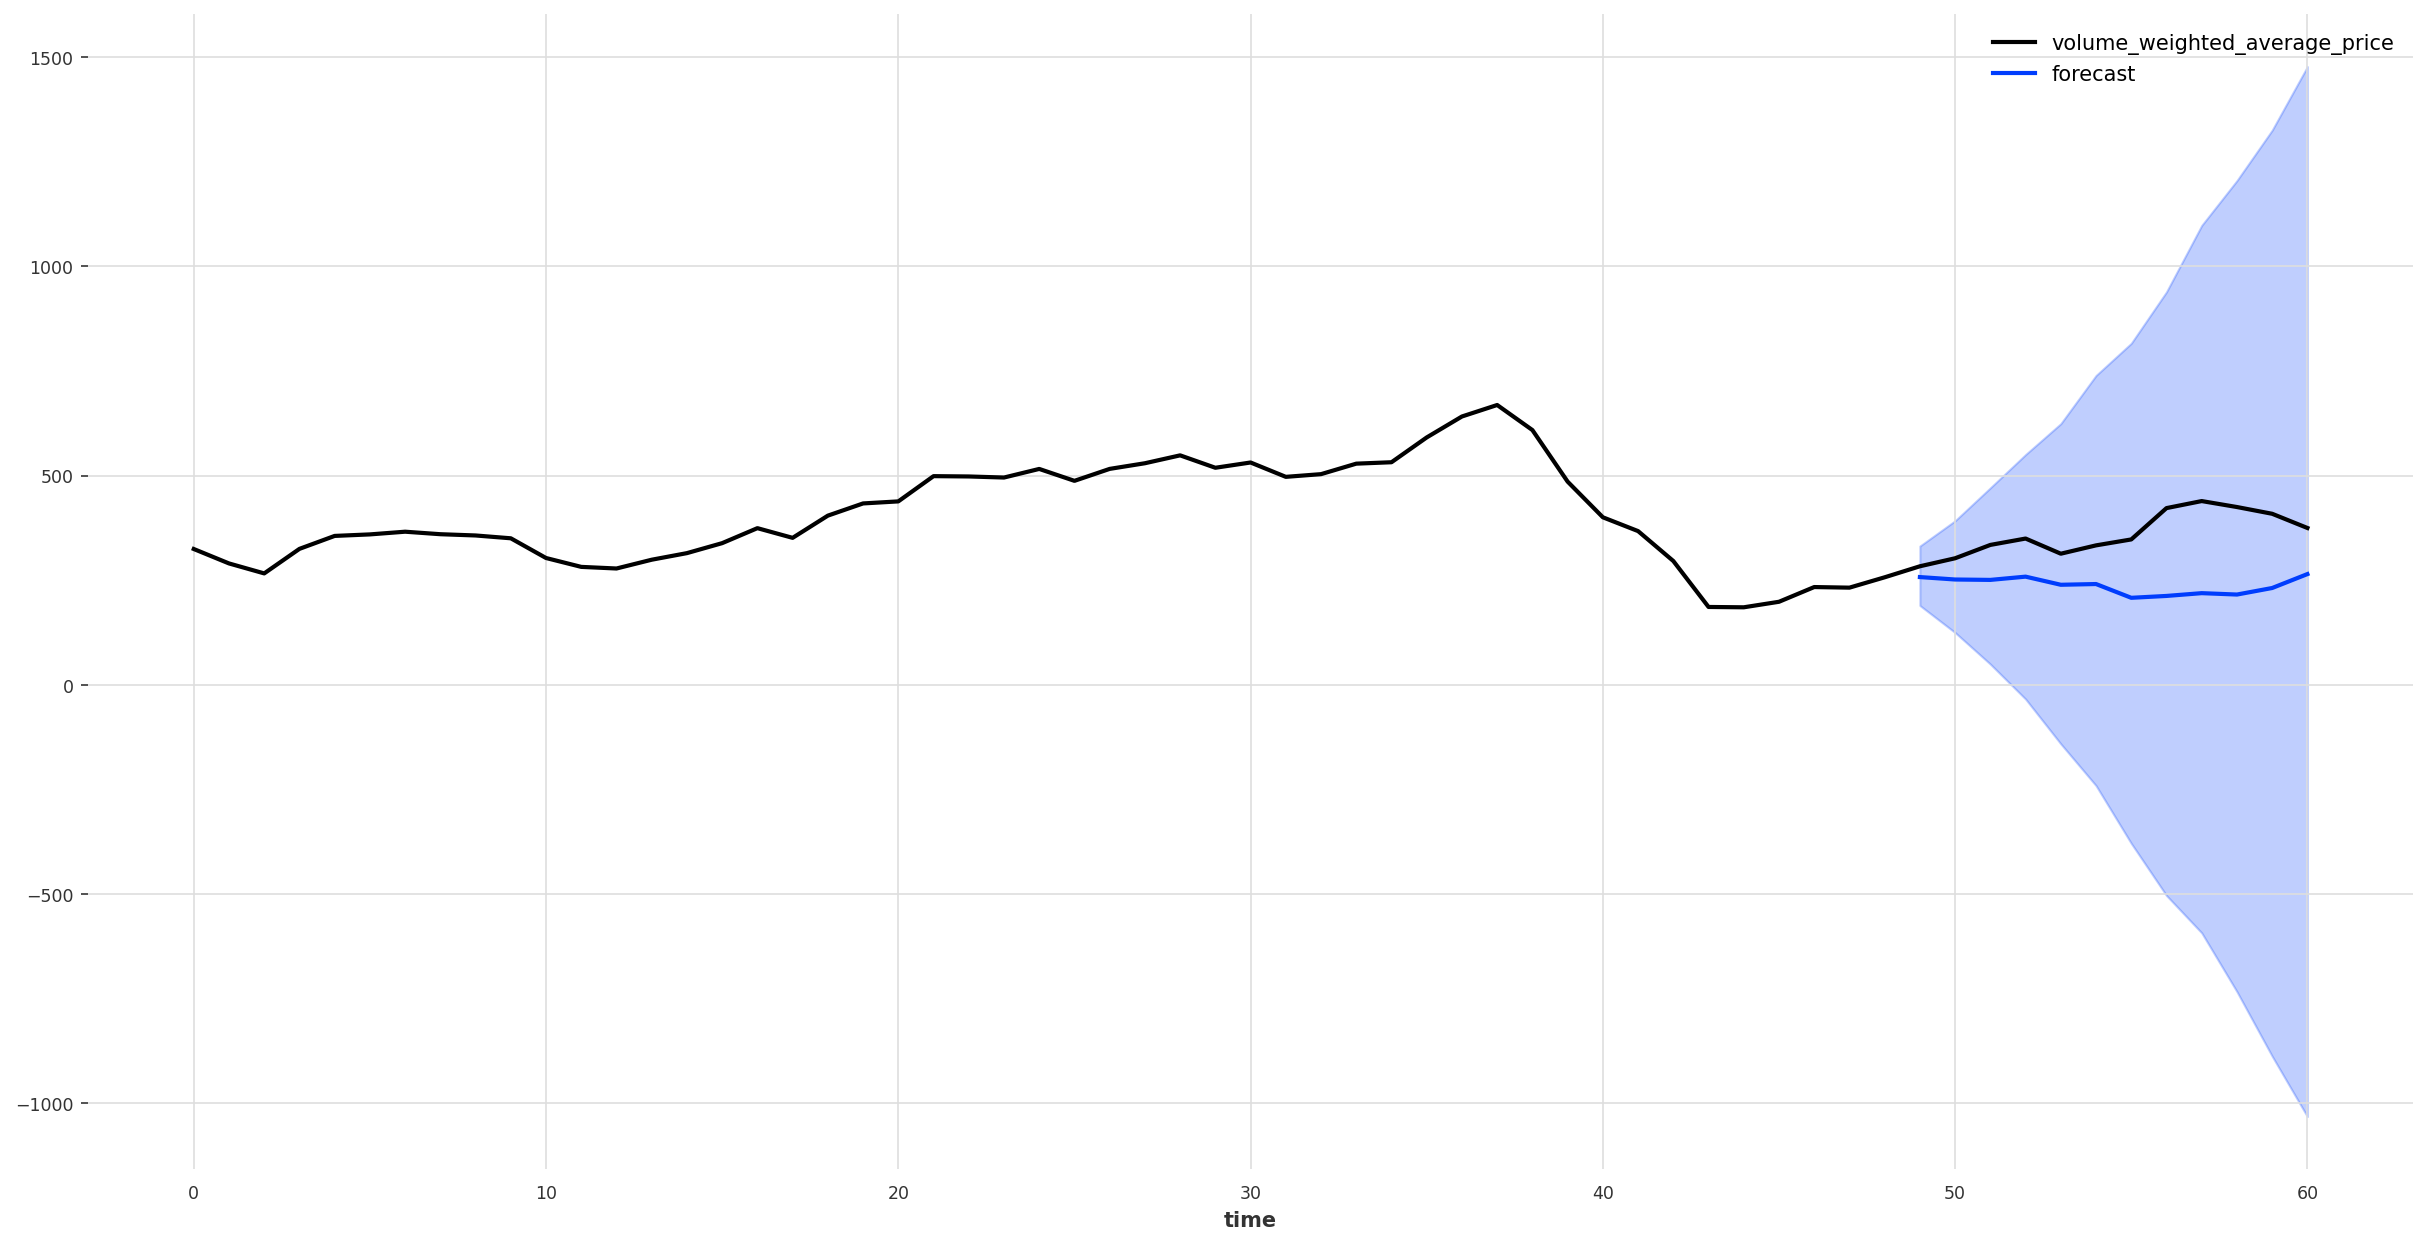

In [257]:
plt.figure(figsize=(20, 10), dpi=150)
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [258]:
pred = model.predict(24)

In [259]:
pred_dates = max_dt + relativedelta(months=24)
dates = pd.date_range(max_dt, pred_dates, freq='M')
dates_df = pd.DataFrame(dates)

In [260]:
dates_df['pred'] = pred.values()
df = TARGET_DF['volume_weighted_average_price'].reset_index()
df['date']=pd.to_datetime(df['date'])
dates_df['date']=pd.to_datetime(dates_df[0])

In [261]:
joined = duckdb.sql("""
select case when a.date is null then b.date else a.date end as date, a. volume_weighted_average_price, b.pred
from df as a
full outer join dates_df as b
on extract(month from a. date) = extract(month from b.date)
and extract(year from a. date) = extract(year from b.date)
order by extract(year from a. date), extract(month from a. date), extract(year from b.date), extract(month from b.date)""").df()

In [262]:
joined = joined.set_index('date')

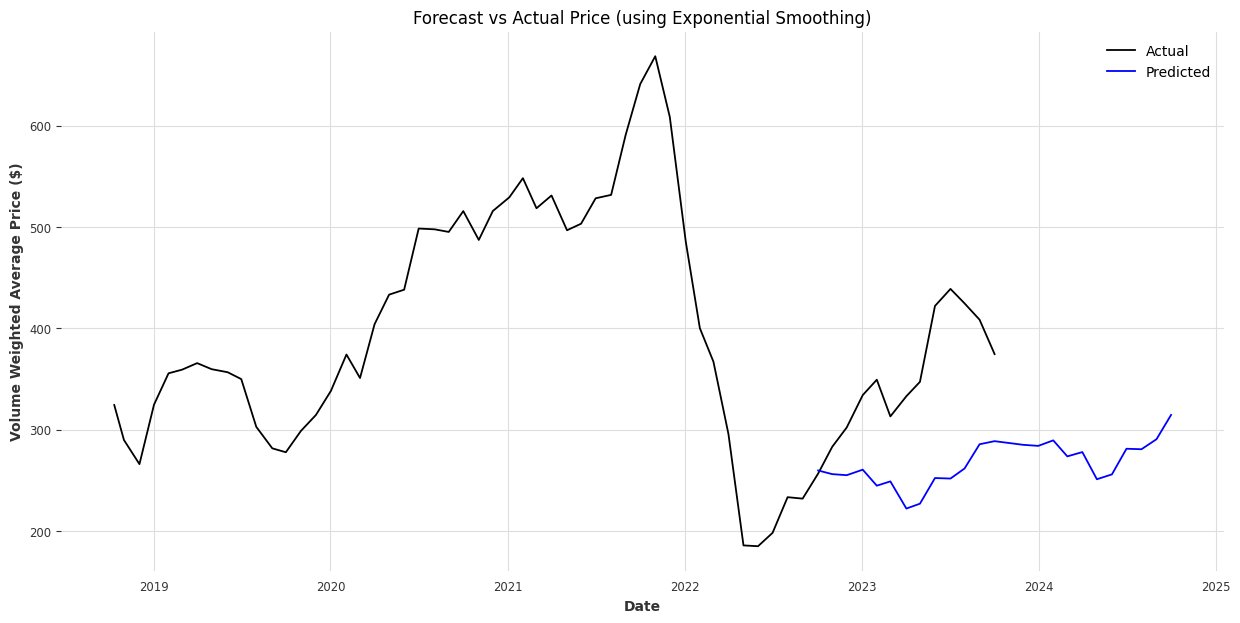

In [263]:
plt.figure(figsize=(15,7))
plt.plot(joined["volume_weighted_average_price"], color='black')
plt.plot(joined["pred"], color='blue')
plt.legend(['Actual', 'Predicted'])
plt.ylabel("Volume Weighted Average Price ($)")
plt.xlabel("Date")
plt.title("Forecast vs Actual Price (using Exponential Smoothing)")
plt.show()

In [264]:
df_overlap = joined.dropna()

In [265]:
df_overlap

,volume_weighted_average_price,pred
date,,
2022-10-03,256.731219,259.779684
2022-11-01,283.093267,256.168031
2022-12-01,302.249952,255.124460
2023-01-03,334.153930,260.570528
2023-02-01,349.383953,244.762546
2023-03-01,313.145730,248.999985
2023-04-03,333.072826,222.191275
2023-05-01,347.264291,226.980375
2023-06-01,422.165319,252.295202


In [266]:
df_overlap['diff'] =  np.square(df_overlap['pred']- df_overlap['volume_weighted_average_price'])

In [267]:
duckdb.sql("SELECT sqrt(sum(diff)/count(*)) as RMSE from df_overlap").df()

,RMSE
0,112.031146
